In [1]:
%matplotlib inline
import cv2 #　opencvのインポート
import matplotlib
import matplotlib.pyplot as plt # matplotlib(描画用)
import numpy as np
import math, time
from scipy.cluster.hierarchy import linkage,dendrogram, fcluster
from numba import jit, njit, prange

print('opencv version: ' + cv2.__version__)
print('matplotlib version: ' + matplotlib.__version__)
print('numpy version: ' + np.__version__)

opencv version: 4.1.2
matplotlib version: 3.2.2
numpy version: 1.18.5


In [2]:
# このセルはGoogle Colaboratory使用時のみ必要
from google.colab import files
f = files.upload() # ファイルアップロード

Saving GINja.png to GINja (3).png
Saving left.jpg to left (2).jpg


> 9.2. Implement a Hough transform based line finder.

以下, 自作したハフ変換の実装を示す.

なお, 以下サイトを参考にした.  

- Hough変換の原理と実装  

Hough変換による画像からの直線や円の検出  
https://codezine.jp/article/detail/153  

In [3]:
## Utilities
# パスから画像をRGBで取得
def GetImage(file_path, cv_option=cv2.COLOR_BGR2RGB, is_show=False):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img, cv_option)
  print('image shape: ' + str(img.shape))

  if is_show:
    plt.title('Acquired Image'), plt.xticks([]), plt.yticks([])
    plt.imshow(img)

  return img

# オリジナル画像を表示
def ShowOriginal(file_path):
  GetImage(file_path)
  plt.title('Original Image')
  plt.imshow(img)

def GetBinaryEdged(img, edge_th=(100, 200), bin_th=1, is_show=False):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  edges = cv2.Canny(gray, *edge_th) # Canny法によるエッジ検出

  # 投票時の簡単化のため2値化
  _, bin = cv2.threshold(edges, bin_th, 255, cv2.THRESH_OTSU)

  if is_show:
    plt.title('Acquired Edge Image')
    plt.imshow(bin, cmap='gray')
  
  return np.array(bin)

In [4]:
def HoughVote(edged_img, theta_split=180):
  img_h, img_w = edged_img.shape
  rho_max = int(np.sqrt(img_h*img_h + img_w*img_w))

  # 白画素（対象画素）をρ-θ空間に投票する
  indices = np.where(edged_img == 255)
  print('the number of targets: ' + str(len(indices[0])))
  return VoteTargets(indices[0], indices[1], rho_max, theta_split)

@njit('u1[:,:](i8[:], i8[:], i8, i8)')
def VoteTargets(ys, xs, rho_max, theta_split):
  counter = np.zeros((2*rho_max, theta_split), dtype=np.uint8) # 投票カウンタ

  for i in range(len(ys)):
    y = ys[i]
    x = xs[i]

    for theta in range(theta_split):
      rad = np.radians((theta / theta_split) * 180) # 0 <= θ(°) < 180
      rho = x * np.cos(rad) + y * np.sin(rad)
      counter[(int)(rho+rho_max)][theta] += 1 # 投票

  return counter

In [5]:
def GetHoughLines(edges, theta_split=180, min_vote_cnt=100, max_line_num=10):
  # ハフ変換によるρ-θ空間への投票結果を取得
  counter = HoughVote(edges, theta_split=theta_split)

  # カウントが大きい順にソートし, 投票数の多いインデックスを取得
  sorted = counter.ravel().argsort()[::-1]
  large_votes_indices = [np.unravel_index(flatten_idx, counter.shape) for flatten_idx in sorted[:max_line_num]]

  print("(ρ, θ°): 投票数")
  lines = []
  img_h, img_w = edges.shape
  rho_max = int(np.sqrt(img_h*img_h + img_w*img_w))

  for idx in large_votes_indices:
    if counter[idx] < min_vote_cnt:
      break

    # 投票用の離散化したρ-θ空間の値から実数値へ変換
    rho = idx[0] - rho_max
    theta = np.radians((idx[1] / theta_split) * 180)
    lines.append((rho, theta))
    print(str((rho, np.rad2deg(theta))) + ": " + str(counter[idx]))
  
  return lines

In [6]:
def DrawHoughLines(edges, lines):
  edges_copy = cv2.cvtColor(np.copy(edges), cv2.COLOR_GRAY2RGB)
  img_h, img_w = edges.shape

  x = range(0, img_w)
  y = range(0, img_h)

  for line in lines:
    rho = line[0]
    theta = line[1]

    # 検出した直線を描画
    # x, y軸に平行な線のときの0割りの回避のために場合分けしておく
    if np.sin(theta) > 0.5:
      ys = -(np.cos(theta) / np.sin(theta)) * x + rho / np.sin(theta)
      cv2.line(edges_copy, (0, int(ys[0])), (img_w-1, int(ys[img_w-1])), (255, 0, 0), 2)
    else:
      xs = -(np.sin(theta) / np.cos(theta)) * y + rho / np.cos(theta)
      cv2.line(edges_copy, (int(xs[0]), 0), (int(xs[img_h-1]), img_h-1), (255, 0, 0), 2)

  plt.figure(figsize=(8.0, 8.0))
  plt.imshow(edges_copy)

自作したハフ変換による直線検出の関数GetHoughLines()を用いて2つの画像で取得した結果を以下に示す.  

ハフ変換の前に前処理としてCanny法のエッジ検出の結果を2値化している.  
その後, GetHoughLines()で検出した直線をDrawHoughLines()で描画.

GetHoughLines()の引数は次の通り.  
- edges: 2値化されたエッジ画像
- theta_split: θ方向の投票用分割数（default: 180）
- min_vote_cnt: 検出する直線の最小投票数（default: 10）
- max_line_num: 検出する直線の最大本数（default: 100）

image shape: (563, 558, 3)
the number of targets: 30984
(ρ, θ°): 投票数
(462, 90.17578125): 255
(512, 90.52734375): 254
(407, 90.52734375): 254
(464, 90.17578125): 253
(-509, 175.78125): 252
(460, 90.52734375): 252
(307, 90.3515625): 251
(-396, 178.41796875): 250
(85, 5.9765625): 250
(88, 89.47265625000001): 250
elapsed_time:1.6389985084533691[sec]


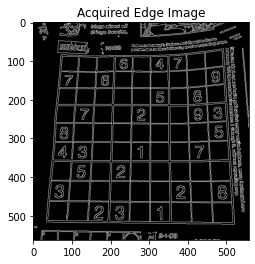

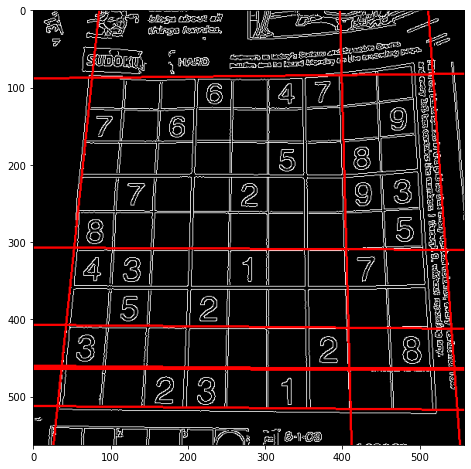

In [7]:
img = GetImage("GINja.png")
edges = GetBinaryEdged(img, is_show=True)

start = time.time()
lines = GetHoughLines(edges, theta_split=1024)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

DrawHoughLines(edges, lines)

image shape: (459, 612, 3)
the number of targets: 11213
(ρ, θ°): 投票数
(-96, 173.84765625): 162
(-125, 174.90234375): 156
(-124, 174.7265625): 151
(-95, 173.671875): 147
(179, 89.12109375): 145
(-64, 171.5625): 140
(137, 89.296875): 140
(-63, 171.38671875): 140
(150, 90.3515625): 139
(-62, 171.03515625): 139
(150, 90.52734375): 139
(407, 70.6640625): 139
(-277, 176.1328125): 138
(-61, 170.859375): 136
(136, 89.6484375): 135
(150, 90.17578125): 135
(-126, 175.078125): 135
(179, 89.296875): 133
(150, 90.703125): 133
(179, 88.9453125): 129
(-282, 177.1875): 129
(-278, 176.30859375): 128
(-97, 174.0234375): 128
(-123, 174.55078125): 127
(-94, 173.49609375): 127
(151, 89.47265625000001): 125
(-225, 175.95703125): 125
(-60, 170.68359375): 124
(179, 88.76953125): 123
(151, 89.296875): 122
elapsed_time:0.6241893768310547[sec]


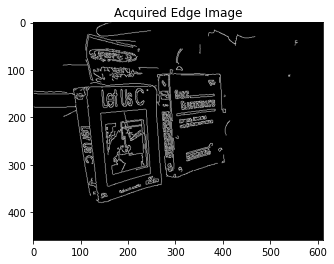

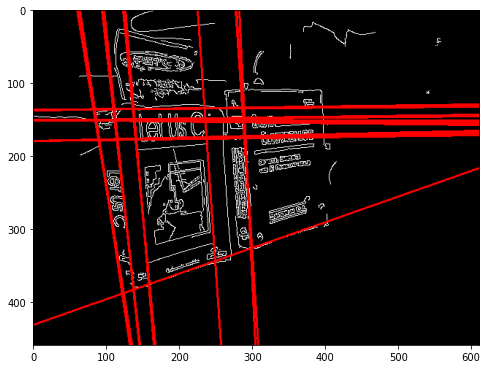

In [8]:
img = GetImage("left.jpg")
edges = GetBinaryEdged(img, is_show=True)

start = time.time()
lines = GetHoughLines(edges, theta_split=1024, min_vote_cnt=100, max_line_num=30)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

DrawHoughLines(edges, lines)